In [1]:
%load_ext autoreload
%autoreload 2

import asyncio, copy, cv2, dlib, os, socket, sys, time
from functools import partial
from multiprocessing import Pool, Process
from pathlib import Path
from tqdm import tqdm

import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import shap
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import nn, resnet, sim, helper
#from cfgs.fedargs import *

/home/harsh_1921cs01/anaconda3/envs/inf/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Device settings
use_cuda = torch.cuda.is_available()
torch.manual_seed(10)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [3]:
def shap_plot(explain, img, size):
    #shap_image = g_img.unsqueeze(0)
    shap_values = explain.shap_values(img.unsqueeze(0))
    
    shap_tensor = torch.tensor(shap_values)
    shap_lists = []
    for i in range(2):
        lsum = 0
        lst = shap_tensor[i].squeeze(0).squeeze(0).view(size).tolist()
        shap_lists.append(lst)
        for l in lst:
            if l > 0:
                lsum += abs(l)
        print ('shap_sum', lsum)
    
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(img.unsqueeze(0).numpy(), 1, -1), 1, 2)
    shap.image_plot(shap_numpy, -test_numpy, None, 20, 0.2, 0.2, None, False)
    #shap.image_plot(shap_values, -shap_image)
    return shap_values

<h1>Gender: ResNet</h1>

In [4]:
df = pd.read_csv('../../data/celeba/list_attr_celeba.txt', sep="\s+", skiprows=1, usecols=['Male', 'Smiling'])

df1 = df[df['Smiling'] == 1]

df1 = df1[['Male']]
print(len(df), len(df1))

# Make 0 (female) & 1 (male) labels instead of -1 & 1
df1.loc[df1['Male'] == -1, 'Male'] = 0

df1.tail()

202599 97669


,Male
202592.jpg,0
202593.jpg,0
202596.jpg,1
202597.jpg,1
202598.jpg,0


In [5]:
df2 = pd.read_csv('../../data/celeba/list_eval_partition.txt', sep="\s+", skiprows=0, header=None)
df2.columns = ['Filename', 'Partition']
df2 = df2.set_index('Filename')

df2.tail()

,Partition
Filename,
202595.jpg,2
202596.jpg,2
202597.jpg,2
202598.jpg,2
202599.jpg,2


In [6]:
df3 = df1.merge(df2, left_index=True, right_index=True)
df3.tail()

,Male,Partition
202592.jpg,0,2
202593.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2
202598.jpg,0,2


In [7]:
df3.to_csv('celeba-gender-partitions.csv')
df4 = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df4.tail()

,Male,Partition
202592.jpg,0,2
202593.jpg,0,2
202596.jpg,1,2
202597.jpg,1,2
202598.jpg,0,2


In [8]:
df4.loc[df4['Partition'] == 0].to_csv('celeba-gender-train.csv')
df4.loc[df4['Partition'] == 1].to_csv('celeba-gender-valid.csv')
df4.loc[df4['Partition'] == 2].to_csv('celeba-gender-test.csv')

(218, 178, 3)


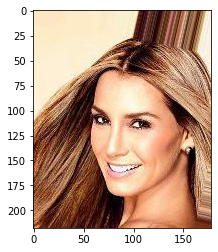

In [9]:
img = Image.open('../../data/celeba/img_align_celeba/000001.jpg')
print(np.asarray(img, dtype=np.uint8).shape)
plt.imshow(img);

In [10]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [11]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally
BATCH_SIZE = 256

custom_transform = transforms.Compose([transforms.CenterCrop((178, 178)),
                                       transforms.Resize((128, 128)),
                                       #transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = CelebaDataset(csv_path='celeba-gender-train.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='celeba-gender-valid.csv',
                              img_dir='../../data/celeba/img_align_celeba/',
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='celeba-gender-test.csv',
                             img_dir='../../data/celeba/img_align_celeba/',
                             transform=custom_transform)


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

In [12]:
target_model = resnet.ResNet18(2)
#MS_FS
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MS30K_FS_30K)_3e_pth", map_location ='cpu'))
#MNS_FNS
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MNS_30K_FNS_30K)_pth", map_location ='cpu'))
#MNS_FS
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MNS_30K_FS_30K)_pth", map_location ='cpu'))
#MS_FNS
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MS_30K_FNS_30K)_pth", map_location ='cpu'))
#MS_30_MNS_10_FS_30_FNS_10
#target_model.load_state_dict(torch.load("../../out/models/PIA_result/TM(MS_30K_MNS_10K_FS_30K_FNS_10K)_pth", map_location ='cpu'))
#MS_10_MNS_30_FS_10_FNS_30
target_model.load_state_dict(torch.load("../../out/models/PIA_HK/TM(MS_30K_FS_30K)_3E_HK.pth", map_location ='cpu'))
target_model.eval()
print("Model Loaded")

Model Loaded


<h1>SHAP Explain</h1>

tensor(0)


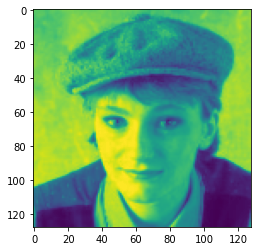

In [63]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

target_batch = next(iter(test_loader))
target_images, target_labels = target_batch
target_baseline = target_images
    
target_explain = shap.DeepExplainer(target_model, target_baseline)
target_image = target_images[154]
plt.imshow(target_image.numpy()[0])
print(target_labels[0])

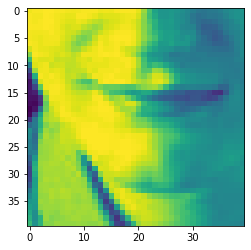

In [64]:
r_img = torch.tensor([[[0.0 for col in range(128)] for row in range(128)] for dim in range(3)])
r_img = target_images[5]
#z_img = z_img.reshape(1,28,28)
r_img.shape
#plt.imshow(z_img.numpy().squeeze())
plt.imshow(target_image[0:3, 80:120, 40:80].numpy()[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 956.0861051081897
shap_sum 1235.5400588034147


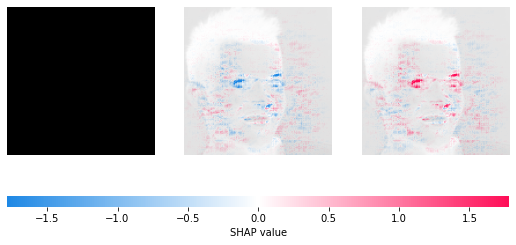

In [62]:
target_shap_values = shap_plot(target_explain, r_img, 49152)
target_female = torch.tensor(target_shap_values[0]).view(-1) 
target_male = torch.tensor(target_shap_values[1]).view(-1)

###
target_female_crop = torch.tensor(target_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
target_male_crop = torch.tensor(target_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 

<h1>PIA</h1>

In [19]:
target_male_smile_crop = target_male_crop

In [ ]:
res = 

<h1>SM1</h1>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 1020.7276318661343
shap_sum 1264.7271996309637


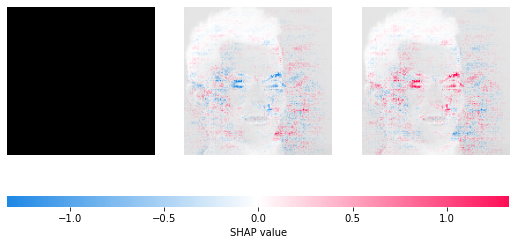

In [119]:
sm1_model = resnet.ResNet18(2)
sm1_model.load_state_dict(torch.load("../../out/models/PIA_HK/sm(ms_5k_fs_5k)_3e_hk.pth", map_location ='cpu'))
sm1_model.eval()
sm1_explain = shap.DeepExplainer(sm1_model, target_baseline)
sm1_shap_values = shap_plot(sm1_explain, r_img, 49152)
sm1_female = torch.tensor(sm1_shap_values[0]).view(-1) 
sm1_male = torch.tensor(sm1_shap_values[1]).view(-1)

###
sm1_female_crop = torch.tensor(sm1_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
sm1_male_crop = torch.tensor(sm1_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 

<h1>SM2</h1>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 828.0038408560972
shap_sum 964.7125312154517


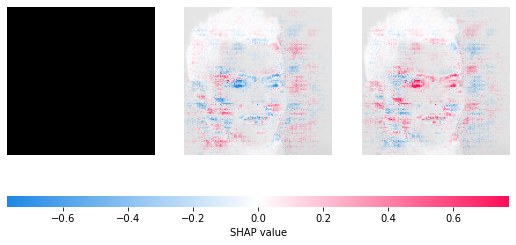

In [120]:
sm2_model = resnet.ResNet18(2)
sm2_model.load_state_dict(torch.load("../../out/models/PIA_HK/sm(mns_5k_fns_5k)_3e_hk.pth", map_location ='cpu'))
sm2_model.eval()
sm2_explain = shap.DeepExplainer(sm2_model, target_baseline)
sm2_shap_values = shap_plot(sm2_explain, r_img, 49152)
sm2_female = torch.tensor(sm2_shap_values[0]).view(-1) 
sm2_male = torch.tensor(sm2_shap_values[1]).view(-1)

###
sm2_female_crop = torch.tensor(sm2_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
sm2_male_crop = torch.tensor(sm2_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 

<h1>SM3</h1>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 798.664368086432
shap_sum 1027.4519541795034


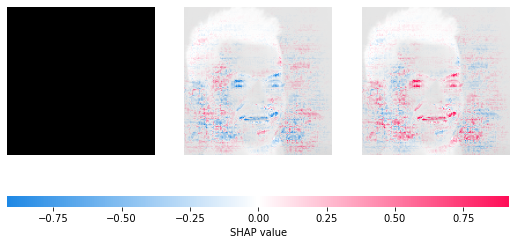

In [121]:
sm3_model = resnet.ResNet18(2)
sm3_model.load_state_dict(torch.load("../../out/models/PIA_HK/sm(ms_5k_fns_5k)_3e_hk.pth", map_location ='cpu'))
sm3_model.eval()
sm3_explain = shap.DeepExplainer(sm3_model, target_baseline)
sm3_shap_values = shap_plot(sm3_explain, r_img, 49152)
sm3_female = torch.tensor(sm3_shap_values[0]).view(-1) 
sm3_male = torch.tensor(sm3_shap_values[1]).view(-1)

###
sm3_female_crop = torch.tensor(sm3_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
sm3_male_crop = torch.tensor(sm3_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 

<h1>SM4</h1>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 955.6799563389177
shap_sum 998.8355927380526


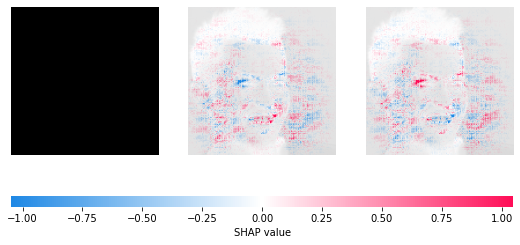

In [122]:
sm4_model = resnet.ResNet18(2)
sm4_model.load_state_dict(torch.load("../../out/models/PIA_HK/sm(mns_5k_fs_5k)_3e_hk.pth", map_location ='cpu'))
sm4_model.eval()
sm4_explain = shap.DeepExplainer(sm4_model, target_baseline)
sm4_shap_values = shap_plot(sm4_explain, r_img, 49152)
sm4_female = torch.tensor(sm4_shap_values[0]).view(-1) 
sm4_male = torch.tensor(sm4_shap_values[1]).view(-1)

###
sm4_female_crop = torch.tensor(sm4_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
sm4_male_crop = torch.tensor(sm4_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 

<h1>SM5</h1>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 1664.9862693213563
shap_sum 1942.3033238445623


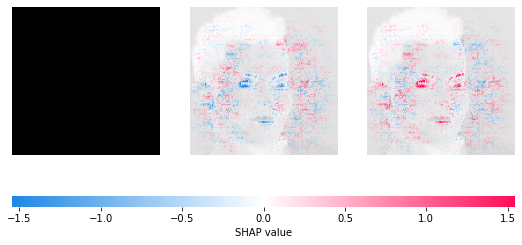

In [123]:
sm5_model = resnet.ResNet18(2)
sm5_model.load_state_dict(torch.load("../../out/models/PIA_HK/sm(ms_3k_mns_1k_fs_3k_fns_1k)_3e_hk.pth", map_location ='cpu'))
sm5_model.eval()
sm5_explain = shap.DeepExplainer(sm5_model, target_baseline)
sm5_shap_values = shap_plot(sm5_explain, r_img, 49152)
sm5_female = torch.tensor(sm5_shap_values[0]).view(-1) 
sm5_male = torch.tensor(sm5_shap_values[1]).view(-1)

###
sm5_female_crop = torch.tensor(sm5_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
sm5_male_crop = torch.tensor(sm5_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 

<h1>SM6</h1>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shap_sum 1034.4260822258261
shap_sum 1287.9224556081365


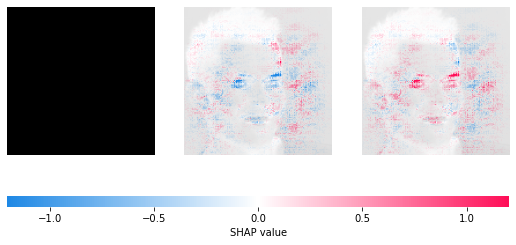

In [124]:
sm6_model = resnet.ResNet18(2)
sm6_model.load_state_dict(torch.load("../../out/models/PIA_HK/sm(ms_1k_mns_3k_fs_1k_fns_3k)_3e_hk.pth", map_location ='cpu'))
sm6_model.eval()
sm6_explain = shap.DeepExplainer(sm6_model, target_baseline)
sm6_shap_values = shap_plot(sm6_explain, r_img, 49152)
sm6_female = torch.tensor(sm6_shap_values[0]).view(-1) 
sm6_male = torch.tensor(sm6_shap_values[1]).view(-1)

###
sm6_female_crop = torch.tensor(sm6_shap_values[0][0:1, 0:3, 80:120, 40:80]).view(-1) 
sm6_male_crop = torch.tensor(sm6_shap_values[1][0:1, 0:3, 80:120, 40:80]).view(-1) 

# cosine similarity 

In [125]:
print(sim.cosine_similarity(target_female, sm1_female))
print(sim.cosine_similarity(target_female, sm2_female))
print(sim.cosine_similarity(target_female, sm3_female))
print(sim.cosine_similarity(target_female, sm4_female))
print(sim.cosine_similarity(target_female, sm5_female))
print(sim.cosine_similarity(target_female, sm6_female))

0.40378433
0.402132
0.3028568
0.22638841
0.32402223
0.38918927


In [126]:
print(sim.cosine_similarity(target_male, sm1_male))
print(sim.cosine_similarity(target_male, sm2_male))
print(sim.cosine_similarity(target_male, sm3_male))
print(sim.cosine_similarity(target_male, sm4_male))
print(sim.cosine_similarity(target_male, sm5_male))
print(sim.cosine_similarity(target_male, sm6_male))

0.40557867
0.39965895
0.30336195
0.22602324
0.3250884
0.39326036


<h1>Eucledian Distance</h1>

In [127]:
print(sim.eucliden_dist(target_female, sm1_female))
print(sim.eucliden_dist(target_female, sm2_female))
print(sim.eucliden_dist(target_female, sm3_female))
print(sim.eucliden_dist(target_female, sm4_female))
print(sim.eucliden_dist(target_female, sm5_female))
print(sim.eucliden_dist(target_female, sm6_female))

21.13866497811935
19.878920939543832
21.374266368926072
22.65600430362315
28.89087622591961
21.975013423134307


In [128]:
print(sim.eucliden_dist(target_male, sm1_male))
print(sim.eucliden_dist(target_male, sm2_male))
print(sim.eucliden_dist(target_male, sm3_male))
print(sim.eucliden_dist(target_male, sm4_male))
print(sim.eucliden_dist(target_male, sm5_male))
print(sim.eucliden_dist(target_male, sm6_male))

21.580223545677896
20.22573728122128
21.739530428987937
23.309572332800958
29.15615629027844
22.114389389383213


<h1>Cropped Cosine Sim</h1>

In [129]:
print(sim.cosine_similarity(target_female_crop, sm1_female_crop))
print(sim.cosine_similarity(target_female_crop, sm2_female_crop))
print(sim.cosine_similarity(target_female_crop, sm3_female_crop))
print(sim.cosine_similarity(target_female_crop, sm4_female_crop))
print(sim.cosine_similarity(target_female_crop, sm5_female_crop))
print(sim.cosine_similarity(target_female_crop, sm6_female_crop))

0.3541661
0.28771532
0.2536459
0.07234012
0.20566447
0.2055831


In [130]:
print(sim.cosine_similarity(target_male_crop, sm1_male_crop))
print(sim.cosine_similarity(target_male_crop, sm2_male_crop))
print(sim.cosine_similarity(target_male_crop, sm3_male_crop))
print(sim.cosine_similarity(target_male_crop, sm4_male_crop))
print(sim.cosine_similarity(target_male_crop, sm5_male_crop))
print(sim.cosine_similarity(target_male_crop, sm6_male_crop))

0.354584
0.2876844
0.25195143
0.07351578
0.20578973
0.20490865
